# RNN으로 이름 생성하기
https://tutorials.pytorch.kr/intermediate/char_rnn_generation_tutorial.html

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import unicodedata
import string
import random
from time import time
import matplotlib.pyplot as plt

In [103]:
all_letters = string.ascii_letters + " .,-"
n_letters = len(all_letters) + 1

def utoa(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def one_hot(s):
    tensor = torch.zeros(len(s), 1, n_letters)
    for i, c in enumerate(s):
        tensor[i][0][all_letters.find(c)] = 1
    return tensor

def load_name_data(path):
    # path = "../data/names/"
    data = {}
    for i, j in enumerate(os.listdir(path)):
        with open(path + j, "r") as f:
            key = j[:-4]
            data[key] = [utoa(s) for s in f.read().split()]
    label = list(data.keys())
    return data, label

def random_sample(data, label):
    key = random.choice(label)
    z = torch.zeros(1, len(label))
    y = torch.tensor([label.index(key)], dtype=torch.long)
    z[0][y] = 1
    item = random.choice(data[key])
    x = one_hot(item)
    target = torch.zeros(len(item), dtype=torch.long)
    target[:-1] = torch.where(x==1)[2][1:]
    target[-1] = n_letters - 1
    return x, item, y, key, z, target

In [104]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, n_categories, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [107]:
data, label = load_name_data("../data/names/")
x, item, y, key, z, target = random_sample(data, label)
target

tensor([ 8,  9, 13,  3,  4, 17, 18, 56])

In [108]:
n_hidden = 128
n_output = len(data.keys())
rnn = RNN(n_output, n_letters, n_hidden, n_letters)

criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)
n_iters = 100000
plot_every = 5000

n_output

18

In [109]:
all_losses = []
cur_loss = 0
start_time = time()

for iter in range(1, n_iters + 1):
    x, item, y, key, z, target = random_sample(data, label)
    optimizer.zero_grad()
    h = rnn.initHidden()
    loss = 0
    for i in range(len(item)):
        out, h = rnn(z, x[i], h)
        loss += criterion(out, torch.LongTensor([target[i]]))
    loss.backward()
    optimizer.step()
    cur_loss += loss.item() / len(item)
    
    if iter % plot_every == 0:
        plot_loss = cur_loss / plot_every
        all_losses.append(plot_loss)
        cur_loss = 0
        print("%d %.4fs %.4f" % (iter, time() - start_time, plot_loss))

5000 17.4610s 2.7014
10000 36.0258s 2.4527
15000 53.1676s 2.3940
20000 69.6561s 2.3393
25000 88.1974s 2.3324
30000 106.7009s 2.2991
35000 124.6181s 2.2912
40000 141.2460s 2.2767
45000 158.0062s 2.2769
50000 177.2050s 2.2585
55000 194.2241s 2.2548
60000 210.7808s 2.2422
65000 228.5170s 2.2338
70000 247.4807s 2.2431
75000 266.8652s 2.2424
80000 286.4062s 2.2432
85000 305.0896s 2.2493
90000 323.7011s 2.2381
95000 341.9143s 2.2296
100000 360.2081s 2.2239


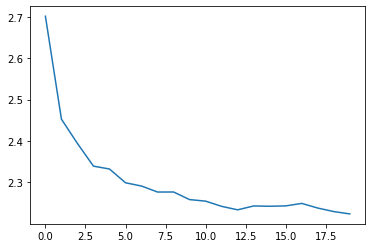

In [110]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [193]:
def sample(category, start_letters='Me', max_length=10):
    with torch.no_grad():
        result = start_letters
        x = one_hot(start_letters)
        z = torch.zeros(1, n_output)
        z[0][label.index(category)] = 1
        h = rnn.initHidden()
        for i in range(len(start_letters)):
            out, h = rnn(z, x[i], h)
        while len(result) < max_length:
            idx = out.argmax()
            if idx == n_letters - 1:
                break
            x = one_hot(all_letters[idx])
            out, h = rnn(z, x[0], h)
            result = result + all_letters[idx]
        
    return result

In [194]:
print(sample("English"))
print(sample("Korean"))
print(sample("Chinese"))
print(sample("Japanese"))

Merron
Men
Mei
Metson
